## Face expression detection

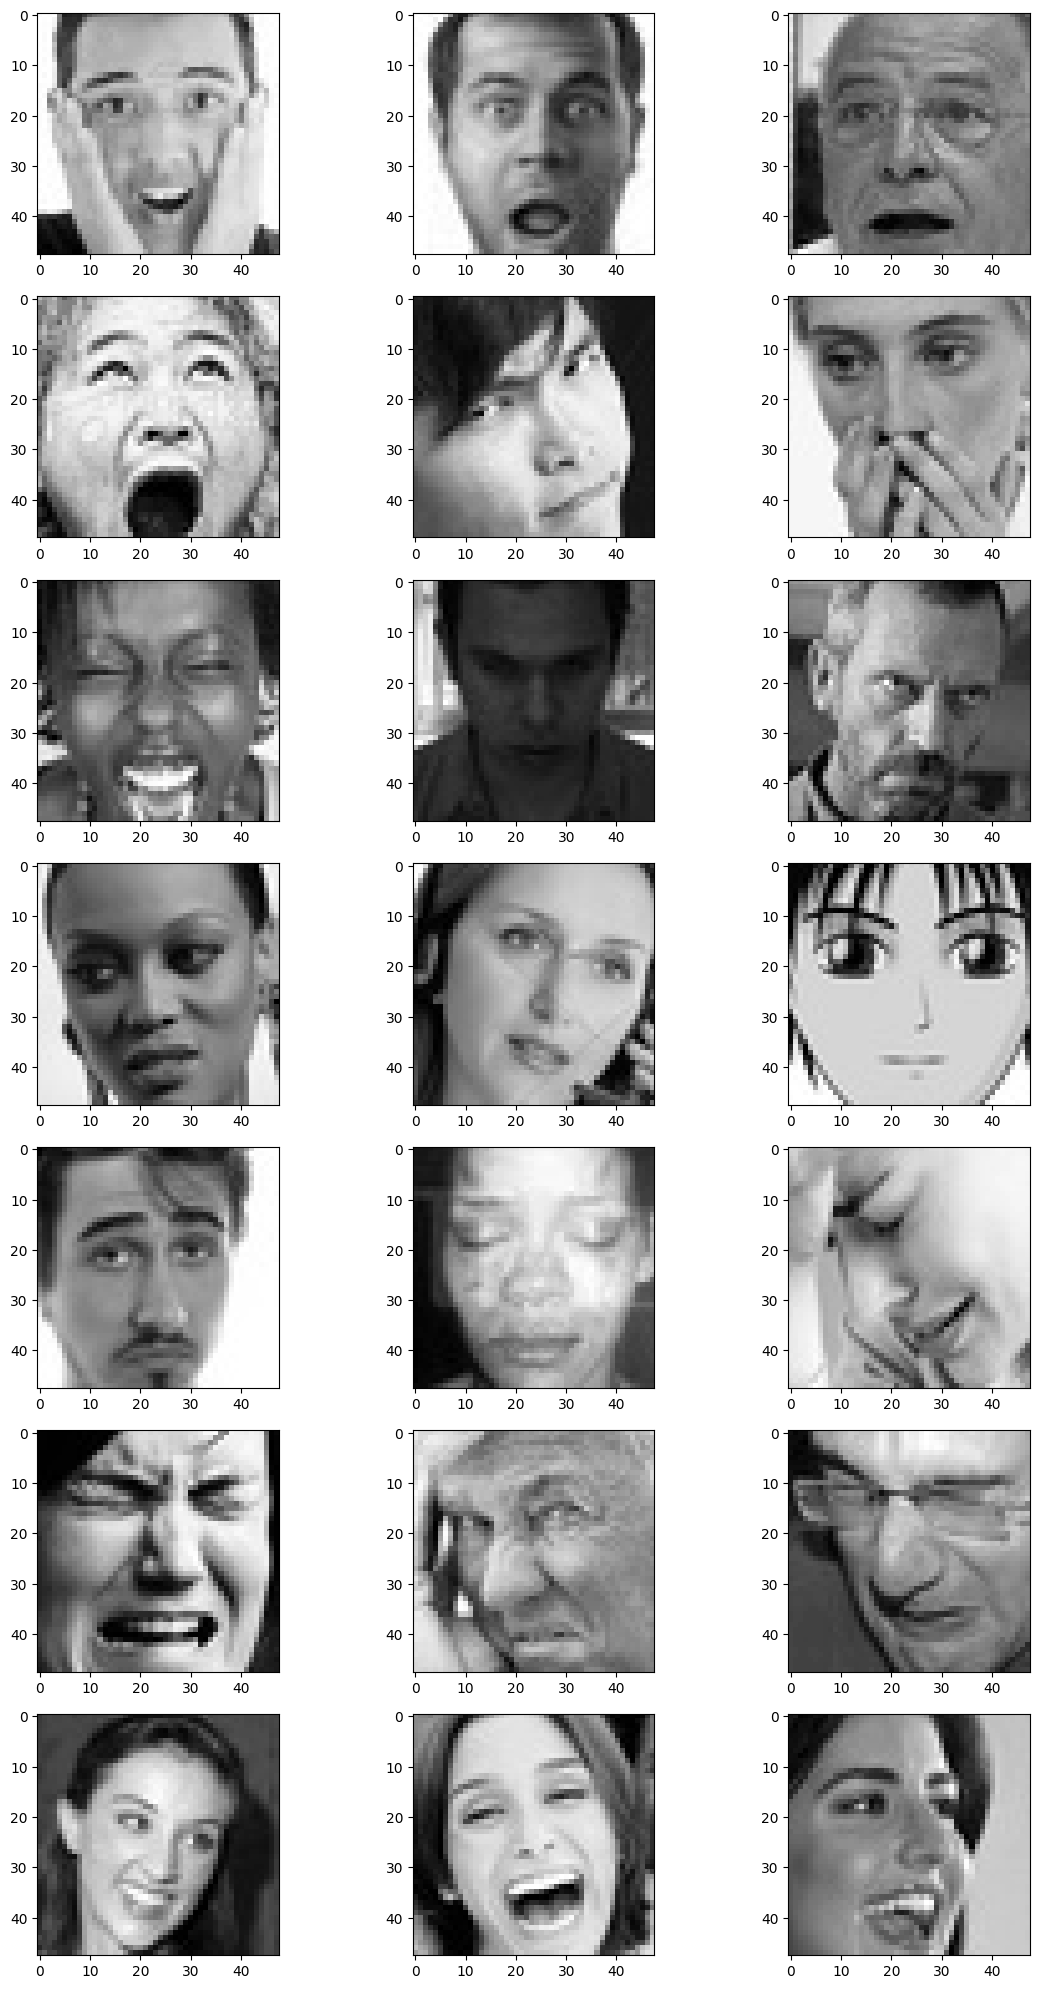

In [1]:
# display some images for every different expression
import os
from PIL import Image
import matplotlib.pyplot as plt

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = "/kaggle/input/face-expression-recognition-dataset/images/train"

plt.figure(0, figsize=(12, 20))
cpt = 0

for expression in os.listdir(base_path):
    #print(f'{expression} contains {len(img_list)} images')
    for i in range(0, 3):
        cpt = cpt + 1
        plt.subplot(7, 3, cpt)
        img_list = os.listdir(os.path.join(base_path, expression))  # Get the list of files in the subdirectory
        img_name = img_list[i]  # Select a specific file by its index
        img_path = os.path.join(base_path, expression, img_name)  # Construct the full image path
        img = Image.open(img_path).convert("L")  # Convert to grayscale
        img = img.resize((pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()


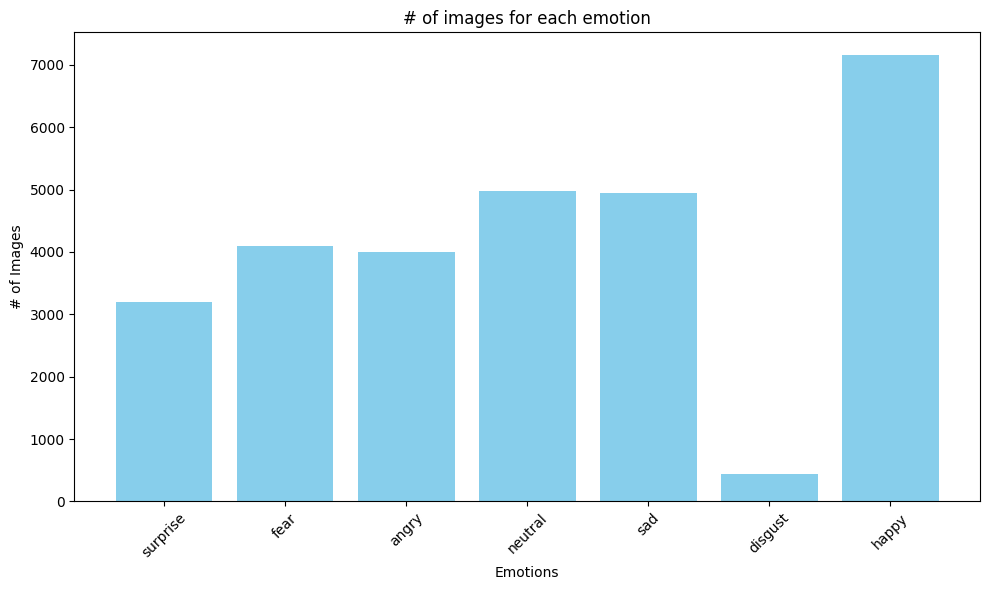

In [2]:
import matplotlib.pyplot as plt

# a dic to store the count of images in each emotion folders
image_counts = {}

# Loop through each emotion folders
for emotion in os.listdir(base_path):
    emotion_path = os.path.join(base_path, emotion)
    if os.path.isdir(emotion_path):
        # Count the number of images in the subfolder
        image_count = len([f for f in os.listdir(emotion_path) if f.endswith('.jpg')])
        image_counts[emotion] = image_count

# Extract the folder names and get the relevant number of images
subfolders = list(image_counts.keys())
counts = list(image_counts.values())

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(subfolders, counts, color='skyblue')
plt.xlabel('Emotions')
plt.ylabel('# of Images')
plt.title('# of images for each emotion')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


## Data augmentation + loading to data loader

In [3]:
# building data generator to work with images
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

batch_size = 128

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Grayscale(num_output_channels=1),  #converting to grayscale -> to have one channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]), #normalizing that one channel
])

train_dataset = ImageFolder(root=base_path, transform=transform)
val_dataset = ImageFolder(root='/kaggle/input/face-expression-recognition-dataset/', transform=transform)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [4]:
for inputs, labels in train_loader:
    print(inputs.shape)
    print(labels.shape)
    break


torch.Size([128, 1, 48, 48])
torch.Size([128])


# Defining the model architecture

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# number of emotions
nb_classes = 7

# Define the CNN for face detection

class FaceCNN(nn.Module):
    def __init__(self, nb_classes):
        super(FaceCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)

        self.conv4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(512 * 3 * 3, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, nb_classes)

    def forward(self, x):
       #first layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        #second layer
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        #third layer
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        #4th layer
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)  #flattening

        # fully connected layer 1
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # fully connected layer 2
        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # fully connected layer 3
        x = self.fc3(x)

        return x

model = FaceCNN(nb_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Training and checking the accuracy

In [7]:
import matplotlib.pyplot as plt

best_val_acc = 0.0
best_model_weights = None
epochs=20

train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Assuming you have your training data (train_loader)
for epoch in range(epochs):
    model.train()   #set model to training mode
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader: #looping through the batches
        inputs, labels = inputs.to(device), labels.to(device)  # Move tensors to GPU
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    print(f'epoch {epoch} loss is {loss.item()}')

    # Compute training loss and accuracy
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    #setting the model to evaluation mode
    model.eval()

    #validation
    total =0
    correct= 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move tensors to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data,1 )
            total += labels.size(0)

            correct += (predicted==labels).sum().item()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    val_acc = correct/total
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'epoch [{epoch+1}/{epochs}], train loss: {epoch_loss:.4f}, train acc: {epoch_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')

    #saving the model if it has the best validation accuracy so far
    if val_acc > best_val_acc:
        best_val_acc =  val_acc
        best_model_weights =  model.state_dict()

epoch 0 loss is 1.7622950077056885
epoch [1/20], train loss: 1.7845, train acc: 0.2648, val loss: 2.1351, val acc: 0.0001
epoch 1 loss is 1.6725660562515259
epoch [2/20], train loss: 1.6384, train acc: 0.3541, val loss: 2.5535, val acc: 0.0009
epoch 2 loss is 1.306807279586792
epoch [3/20], train loss: 1.5500, train acc: 0.3978, val loss: 2.3821, val acc: 0.0038
epoch 3 loss is 1.3689466714859009
epoch [4/20], train loss: 1.4912, train acc: 0.4204, val loss: 2.3717, val acc: 0.0220
epoch 4 loss is 1.4005287885665894
epoch [5/20], train loss: 1.4363, train acc: 0.4459, val loss: 2.6890, val acc: 0.0415
epoch 5 loss is 1.600218415260315
epoch [6/20], train loss: 1.3963, train acc: 0.4636, val loss: 2.9625, val acc: 0.0439
epoch 6 loss is 1.6096410751342773
epoch [7/20], train loss: 1.3553, train acc: 0.4793, val loss: 2.8266, val acc: 0.0712
epoch 7 loss is 1.2597700357437134
epoch [8/20], train loss: 1.3342, train acc: 0.4870, val loss: 3.2667, val acc: 0.0436
epoch 8 loss is 1.24286735

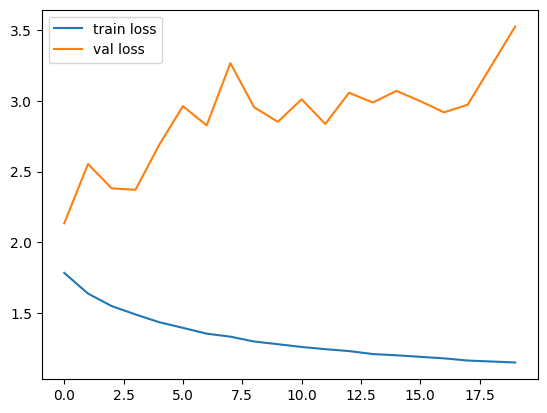

In [8]:
# Plot the training and validation accuracy and loss
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()

In [9]:
print(train_accs)

[tensor(0.2648, device='cuda:0', dtype=torch.float64), tensor(0.3541, device='cuda:0', dtype=torch.float64), tensor(0.3978, device='cuda:0', dtype=torch.float64), tensor(0.4204, device='cuda:0', dtype=torch.float64), tensor(0.4459, device='cuda:0', dtype=torch.float64), tensor(0.4636, device='cuda:0', dtype=torch.float64), tensor(0.4793, device='cuda:0', dtype=torch.float64), tensor(0.4870, device='cuda:0', dtype=torch.float64), tensor(0.5006, device='cuda:0', dtype=torch.float64), tensor(0.5082, device='cuda:0', dtype=torch.float64), tensor(0.5176, device='cuda:0', dtype=torch.float64), tensor(0.5217, device='cuda:0', dtype=torch.float64), tensor(0.5290, device='cuda:0', dtype=torch.float64), tensor(0.5349, device='cuda:0', dtype=torch.float64), tensor(0.5400, device='cuda:0', dtype=torch.float64), tensor(0.5462, device='cuda:0', dtype=torch.float64), tensor(0.5492, device='cuda:0', dtype=torch.float64), tensor(0.5533, device='cuda:0', dtype=torch.float64), tensor(0.5580, device='cuda

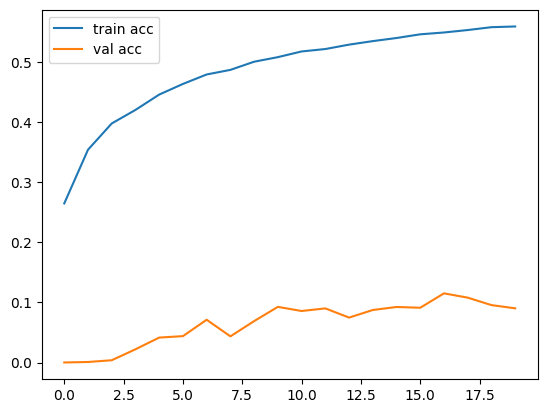

In [10]:
# train_accs and val_accs are lists of PyTorch tensors so we need to get the values only

train_accs_values = [acc.item() for acc in train_accs]

plt.plot(train_accs_values, label='train acc')
plt.plot(val_accs, label='val acc')
plt.legend()
plt.show()

In [11]:
torch.save(best_model_weights, '/kaggle/working/best weights.pth')